📘 XGBoost (eXtreme Gradient Boosting)

**XGBoost** is a highly optimized, scalable implementation of Gradient Boosted Decision Trees (GBDT), widely used for structured/tabular data due to its performance and flexibility.

🔧 Key Features:
- **Regularization**: Incorporates L1 (Lasso) and L2 (Ridge) penalties to control overfitting.
- **Parallel & Distributed Training**: Utilizes hardware-efficient parallelism for fast training.
- **Tree Pruning**: Uses gain and cover-based splitting to reduce unnecessary model complexity.
- **Handling Missing Data**: Learns optimal default directions for missing values during training.
- **Custom Loss Functions**: Allows defining specialized objectives for tasks like ranking and survival analysis.

✅ Strengths:
- State-of-the-art accuracy on structured data.
- Versatile: Supports classification, regression, and ranking.
- Scales efficiently to large datasets.
- Offers built-in feature importance measures (e.g., weight, gain, cover).

⚠️ Weaknesses:
- Sensitive to hyperparameters (e.g., learning rate, max depth).
- Less interpretable than simpler models.
- Can be memory-intensive with very high-dimensional data (e.g., text features in NLP).



# **Import library**

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=72448f1b00eb781cde0f3b16092638fdad6d38991e16302d6933eb7c799b748e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip install shap

In [ ]:
%pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, cv, DMatrix
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import time
import shap
from lime import lime_tabular
# import eli5
from sklearn.inspection import permutation_importance

# **Load the data sets**

In [ ]:
df = pd.read_csv("/content/df_cleaned.csv")
df.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1


# **preprocessing**

In [ ]:
df.shape

(119286, 21)

In [ ]:
df.isna().sum()

,0
last_pymnt_d,0
total_rec_prncp,0
last_pymnt_amnt,0
out_prncp,0
total_rec_late_fee,0
last_fico_range_high,0
installment,0
loan_amnt,0
total_rec_int,0
out_prncp_inv,0


In [ ]:
# Print all column names
print(df.columns.tolist())

['last_pymnt_d', 'total_rec_prncp', 'last_pymnt_amnt', 'out_prncp', 'total_rec_late_fee', 'last_fico_range_high', 'installment', 'loan_amnt', 'total_rec_int', 'out_prncp_inv', 'total_pymnt', 'funded_amnt_inv', 'recoveries', 'debt_settlement_flag', 'hardship_flag', 'mo_sin_old_rev_tl_op', 'revol_util', 'dti', 'all_util', 'annual_inc', 'loan_status']


In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in cat_cols:
      le = LabelEncoder()
      df[col] = le.fit_transform(df[col])
      label_encoders[col] = le

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
y_train.value_counts(normalize=True)

,proportion
loan_status,
1,0.521199
0,0.478801


In [ ]:
y_test.value_counts(normalize=True)

,proportion
loan_status,
1,0.515928
0,0.484072


In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
learning_objective = {'objective':'binary:logistic' }
model = xgb.train(params = learning_objective, dtrain= dtrain)

In [ ]:
test_predictions = model.predict(dtest)
round_test_predictions = [round(p) for p in test_predictions]
accuracy_score(y_test,round_test_predictions)

0.9847849777852292

# **Xgboost implementation**

In [ ]:
def train_xgboost_model(X_train, y_train, X_test, y_test, objective='binary:logistic', eval_metric='auc', tree_method='hist',
                        learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1,
                        reg_lambda=1.0, seed=42, n_jobs=-1):
    """
    Train an XGBoost classifier and return the trained model.

    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - y_test: Test labels
    """
    # Convert to DMatrix (optimized XGBoost data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Parameters aligned with XGBoost's theoretical improvements
    params = {
        'objective': objective,
        'eval_metric': eval_metric,
        'tree_method': tree_method,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'seed': seed,
        'n_jobs': n_jobs
    }

    # Early stopping (prevents overfitting)
    num_rounds = 100
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_rounds,
        evals=watchlist,
        early_stopping_rounds=20,
        verbose_eval=10
    )
    return model

In [ ]:
# Train the XGBoost model
model = train_xgboost_model(X_train, y_train, X_test, y_test)

# Make predictions
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc_score:.4f}")



[0]	train-auc:0.99485	eval-auc:0.99444
[10]	train-auc:0.99796	eval-auc:0.99787
[20]	train-auc:0.99863	eval-auc:0.99848
[30]	train-auc:0.99891	eval-auc:0.99883
[40]	train-auc:0.99912	eval-auc:0.99900
[50]	train-auc:0.99922	eval-auc:0.99908
[60]	train-auc:0.99933	eval-auc:0.99917
[70]	train-auc:0.99940	eval-auc:0.99922
[80]	train-auc:0.99949	eval-auc:0.99923
[90]	train-auc:0.99955	eval-auc:0.99926
[99]	train-auc:0.99959	eval-auc:0.99927
Accuracy: 0.9900
AUC: 0.9993


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Print formatted metrics in a table
print("\nPerformance Metrics:")
print("| Metric    | Score      |")
print("|-----------|------------|")
print(f"| Accuracy  | {accuracy:.1f}%    |")
print(f"| F1 Score  | {f1:.3f}    |")
print(f"| ROC-AUC   | {auc_score:.3f}    |")

# Print the original detailed outputs
print(f"\nDetailed Accuracy: {accuracy:.1f}%")
print(f"Detailed AUC: {auc_score:.4f}")


Performance Metrics:
| Metric    | Score      |
|-----------|------------|
| Accuracy  | 99.0%    |
| F1 Score  | 0.990    |
| ROC-AUC   | 0.999    |

Detailed Accuracy: 99.0%
Detailed AUC: 0.9993


In [ ]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11549
           1       0.99      0.99      0.99     12309

    accuracy                           0.99     23858
   macro avg       0.99      0.99      0.99     23858
weighted avg       0.99      0.99      0.99     23858



<Figure size 1200x600 with 0 Axes>

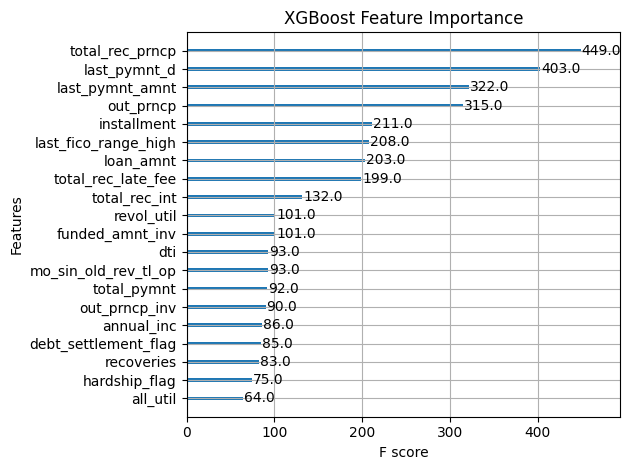

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Get feature importance scores
importance_scores = model.get_score(importance_type='weight')
sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Print top 10 features
print("\nTop 10 Most Important Features:")
print("| Rank | Feature Name       | Importance Score |")
print("|------|--------------------|------------------|")
for i, (feature, score) in enumerate(sorted_features[:20], 1):
    print(f"| {i:<4} | {feature:<18} | {score:<16} |")



Top 10 Most Important Features:
| Rank | Feature Name       | Importance Score |
|------|--------------------|------------------|
| 1    | total_rec_prncp    | 449.0            |
| 2    | last_pymnt_d       | 403.0            |
| 3    | last_pymnt_amnt    | 322.0            |
| 4    | out_prncp          | 315.0            |
| 5    | installment        | 211.0            |
| 6    | last_fico_range_high | 208.0            |
| 7    | loan_amnt          | 203.0            |
| 8    | total_rec_late_fee | 199.0            |
| 9    | total_rec_int      | 132.0            |
| 10   | funded_amnt_inv    | 101.0            |
| 11   | revol_util         | 101.0            |
| 12   | mo_sin_old_rev_tl_op | 93.0             |
| 13   | dti                | 93.0             |
| 14   | total_pymnt        | 92.0             |
| 15   | out_prncp_inv      | 90.0             |
| 16   | annual_inc         | 86.0             |
| 17   | debt_settlement_flag | 85.0             |
| 18   | recoveries         | 

# **EXPLAINABILITY TECHNIQUES**

In [ ]:
print("\n\n=== EXPLAINABILITY TECHNIQUES ===\n")
best_model_type = "XGBoost"
best_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', tree_method='hist',
                        learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_alpha=0.1,
                        reg_lambda=1.0, seed=42, n_jobs=-1)
best_model.fit(X_train, y_train)
print(f"Using {best_model_type.upper()} model for explainability analysis")



=== EXPLAINABILITY TECHNIQUES ===

Using XGBOOST model for explainability analysis


# **Global models**

### **1. Permutation Feature Importance**


--- EXPLAINABILITY #1: Permutation Importance ---


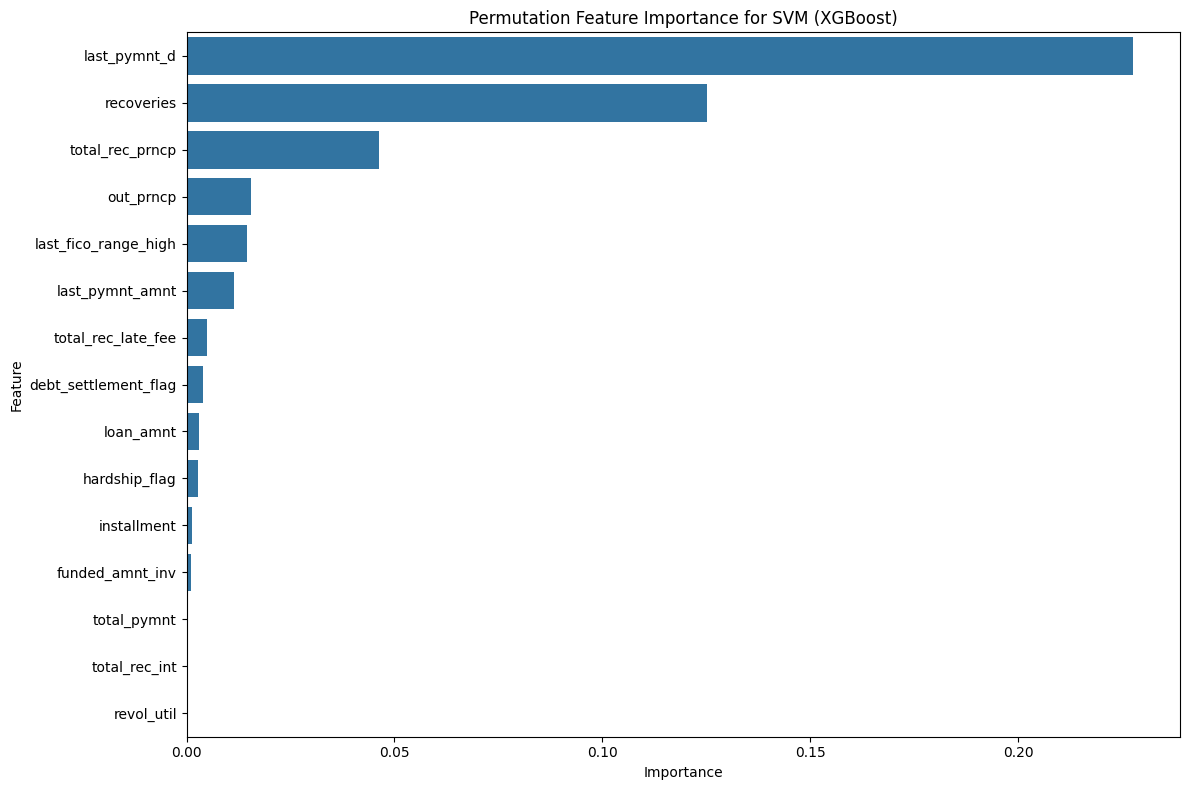

In [ ]:
print("\n--- EXPLAINABILITY #1: Permutation Importance ---")
perm = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title(f'Permutation Feature Importance for SVM ({best_model_type})')
plt.tight_layout()
plt.show()

**Key Insights from Feature Importance Analysis**

- **`last_pymnt_d`** *(last payment date)* and **`recoveries`** are by far the **most influential features**, with a strong impact on the model’s default predictions.
  
- **Moderately important features** include:
  - **`total_rec_prncp`** (total recovered principal)
  - **`out_prncp`** (outstanding principal)
  - **`last_fico_range_high`** (upper bound of last reported FICO score)

- **Low-importance features** such as:
  - **`revol_util`**, **`total_rec_int`**, **`installment`**, etc.
  - These contribute **negligibly** to the model’s performance and may be candidates for feature reduction or simplification.



In [ ]:
print("Top 10 most important features:")
print(feature_importances.head(10))

Top 10 most important features:
                 Feature  Importance
0           last_pymnt_d    0.227605
12            recoveries    0.125258
1        total_rec_prncp    0.046265
3              out_prncp    0.015399
5   last_fico_range_high    0.014511
2        last_pymnt_amnt    0.011384
4     total_rec_late_fee    0.004996
13  debt_settlement_flag    0.003940
7              loan_amnt    0.002875
14         hardship_flag    0.002615


**🔑 Key Takeaways from Feature Importance Analysis**

- **`last_pymnt_d` (0.2276)** and **`recoveries` (0.1255)** are the **most critical features**, dominating the model’s decision-making process.
  
- **Moderate to low impact features**:
  - `total_rec_prncp`
  - `out_prncp`
  - `last_fico_range_high`

- **Minimal contributors**:
  - `loan_amnt`
  - `hardship_flag`
  - These features have **negligible influence** on predictions and may be considered for removal or de-emphasis in future models.


### **2. Partial Dependence Plots (PDP)**

In [ ]:
print("\n--- EXPLAINABILITY #2: Partial Dependence Plots ---")
# Get top features from permutation importance
top_features = feature_importances['Feature'].head(1)
top_features


--- EXPLAINABILITY #2: Partial Dependence Plots ---


,Feature
0,last_pymnt_d


<ipython-input-35-289d1d6dc696>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


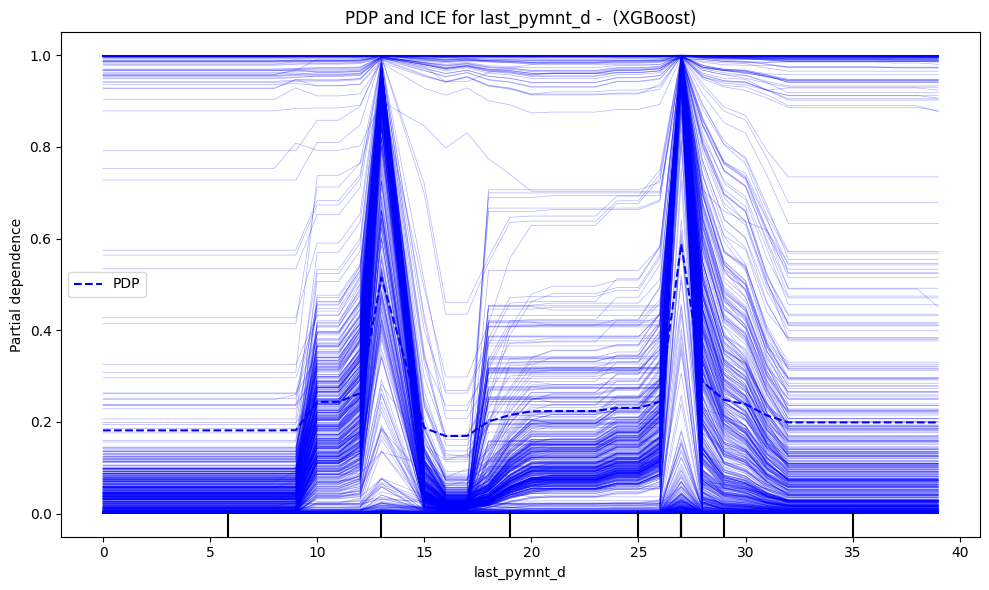

In [ ]:
sample_indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_sample = X_test.iloc[sample_indices]

# Create PDP and ICE plots using PartialDependenceDisplay
top_feature_name = top_features.iloc[0]

fig, ax = plt.subplots(figsize=(10, 6))

# Create PDP and ICE plots in one step with kind='both'
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test_sample,
    [top_feature_name],
    ax=ax,
    line_kw={"color": "blue", "label": "PDP"},
    feature_names=X.columns,
    kind='both'
)

# Customize the ICE lines (optional)
for line in display.lines_[0][1:]:
    line.set_alpha(0.3)
    line.set_color("gray")

ax.set_title(f'PDP and ICE for {top_feature_name} -  ({best_model_type})')
ax.legend()
plt.tight_layout()
plt.show()

Interpretation: PDP and ICE for `last_pymnt_d`

- **PDP (Partial Dependence Plot – dashed line):**
  - Represents the **average effect** of `last_pymnt_d` on the model’s predictions across all data points.
  - The trend is **relatively stable**, but shows **small dips** around values **15** and **30**, suggesting localized sensitivity.

- **ICE (Individual Conditional Expectation – blue lines):**
  - Illustrate how predictions **change individually** as `last_pymnt_d` varies.
  - Many ICE curves exhibit **sharp peaks at 15 and 30**, indicating that the model reacts **strongly and non-linearly** to these specific payment dates.



# **Local models**

### **3. SHAP Values**

100%|===================| 119113/119286 [10:46<00:00]       

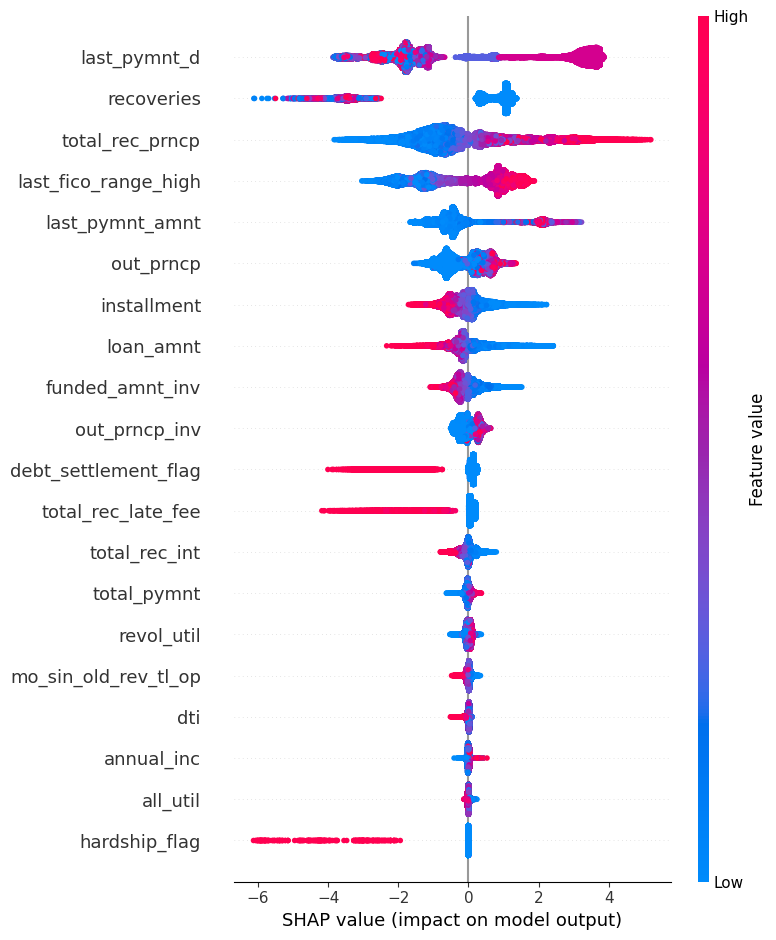

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

🔍 SHAP Value Insights: Feature-Level Impact on Default Prediction

🔴 Strong Positive Impact (Pushes Prediction Toward Default):
- **`last_pymnt_d` (high values)**:  
  A recent last payment (red) strongly increases the predicted default risk.
  
- **`recoveries` (high values)**:  
  High recovery amounts may signal **post-default activity**, thus increasing the predicted risk.

- **`total_rec_prncp` (high values)**:  
  Surprisingly, large principal recoveries can also be linked to increased risk — potentially reflecting prior delinquency or charge-offs.

🔵 Strong Negative Impact (Pushes Prediction Away From Default):
- **`last_pymnt_d` (low values)**:  
  Older last payment dates (blue) are associated with **lower risk** — often a sign of consistent payments.

- **`recoveries` (low values)**:  
  The **absence of recoveries** usually indicates no prior default, hence a lower risk prediction.

- **`total_rec_prncp` (low values)**:  
  Low recovered principal may reflect **fewer historical issues**, leading to a safer outlook in the model.

📉 Lower-Impact Features:
- Features such as `hardship_flag`, `annual_inc`, `all_util`, and `dti` rank lower in importance and exhibit **minimal influence** on the model’s output in the SHAP plot.



### **4. LIME**

In [ ]:
print("\n--- EXPLAINABILITY #4: LIME ---")
# Create a LIME explainer
X_train_np = X_train.values

explainer = lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=X.columns,
    class_names=['Not Default', 'Default'],
    mode='classification'
)


--- EXPLAINABILITY #4: LIME ---


In [ ]:
# Explain the first instance
instance_idx = 0
exp = explainer.explain_instance(
    X_test.iloc[instance_idx].values,
    best_model.predict_proba,
    num_features=10
)

<Figure size 1000x600 with 0 Axes>

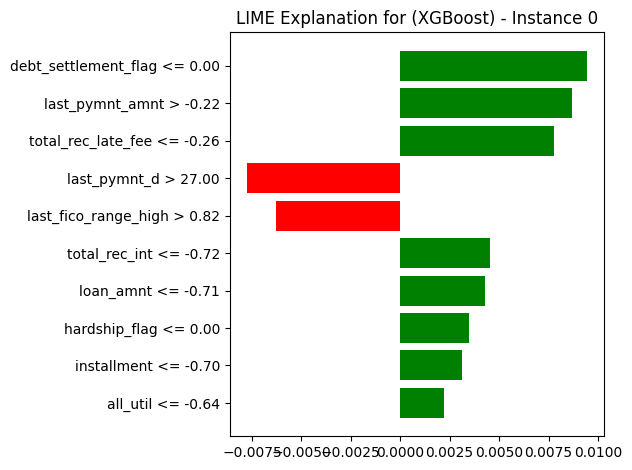

In [ ]:
# Plot the explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for ({best_model_type}) - Instance {instance_idx}')
plt.tight_layout()
plt.show()

🔍 Key Factors Influencing the Model's Prediction

The prediction was driven by a combination of features with both positive and negative impacts:

✅ Strongest Positive Factors (Pushing Toward Approval)
- **`debt_settlement_flag = 0.00`**: No debt settlement involvement — strongest positive influence.
- **`last_pymnt_amnt > -0.22`**: Indicates a recent and substantial payment.
- **`total_rec_late_fee <= -0.26`**: Few or no late fees suggest responsible repayment.

❌ Strongest Negative Factors (Pushing Toward Rejection)
- **`last_fico_range_high > 0.82`**: Surprisingly associated with increased rejection risk, possibly due to feature interactions or data imbalance.
- **`last_pymnt_d > 27.00`**: A long gap since the last payment increases perceived risk.

📉 Other Contributing Factors (Smaller Positive Impacts)
- **`hardship_flag`**, **`loan_amnt`**, **`installment`**, **`total_rec_int`**, and **`all_util`** had minor positive effects on the prediction outcome.


In [ ]:
# Print LIME explanation
print(f"LIME explanation for instance {instance_idx}:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

LIME explanation for instance 0:
debt_settlement_flag <= 0.00: 0.0095
last_pymnt_amnt > -0.22: 0.0087
total_rec_late_fee <= -0.26: 0.0078
last_pymnt_d > 27.00: -0.0078
last_fico_range_high > 0.82: -0.0063
total_rec_int <= -0.72: 0.0045
loan_amnt <= -0.71: 0.0043
hardship_flag <= 0.00: 0.0035
installment <= -0.70: 0.0031
all_util <= -0.64: 0.0022


📊 LIME Explanation – Instance 0

This explanation shows which features had the greatest influence on the model’s prediction for a specific case.

✅ Positive Influences (Favoring Approval)
- **`debt_settlement_flag <= 0.00`** → **+0.0095**  
  No debt settlement history strongly supports approval.
- **`last_pymnt_amnt > -0.22`** → **+0.0087**  
  A higher recent payment amount is a positive signal.
- **`total_rec_late_fee <= -0.26`** → **+0.0078**  
  Few or no late fees indicate good repayment behavior.
- **`total_rec_int <= -0.72`** → **+0.0045**  
  Low recovered interest could imply fewer delays.
- **`loan_amnt <= -0.71`** → **+0.0043**  
  Smaller loan size slightly reduces risk.
- **`hardship_flag <= 0.00`** → **+0.0035**  
  No hardship flag is marginally favorable.
- **`installment <= -0.70`** → **+0.0035**  
  Lower installment amount helps slightly.
- **`all_util <= -0.64`** → **+0.0022**  
  Lower credit utilization slightly reduces risk.

❌ Negative Influences (Pushing Toward Rejection)
- **`last_pymnt_d > 27.00`** → **-0.0071**  
  A recent last payment increases risk.
- **`last_fico_range_high > 0.82`** → **-0.0063**  
  Surprisingly, a higher FICO score hurt this prediction — possibly due to data patterns or model behavior.


In [ ]:
# Display explanation
exp.show_in_notebook(show_table=True)

🔍 Model Prediction Summary – Instance 0

📈 Prediction Probabilities:
- **Predicted Class**: **Default**
- **Probability ("Default")**: **1.00**
- **Probability ("Not Default")**: **0.00**

🧠 Feature Contributions (Middle Section):
Features influencing the prediction outcome:
- **Pushed Toward "Default"** (🔶 Right/Orange):
  - `last_pymnt_d = 38.00`: Indicates recent payment, increases risk.
  - `last_fico_range_high = 1.00`: High score unexpectedly increases risk in this model.
- **Pushed Toward "Not Default"** (🔷 Left/Blue):
  - Most other features had **minimal impact** in this specific prediction.

📊 Actual Feature Values (Right Side):

| Feature                | Value   |
|------------------------|---------|
| `debt_settlement_flag`| 0.00    |
| `last_pymnt_amnt`      | 0.13    |
| `last_pymnt_d`         | 38.00   |
| `last_fico_range_high` | 1.00    |
| `total_rec_int`        | -0.83   |
| `loan_amnt`            | -1.35   |
| `hardship_flag`        | 0.00    |
| `installment`          | -1.32   |
| `all_util`             | -1.28   |


